# Calibration of the Chaboche mecanical model

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = G(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

The variables have the following distributions and are supposed to be independent.

| Random var. | Distribution | 
|--|--|
| $R$ | Lognormal ($\mu = 750$ MPa, $\sigma = 11$ MPa) |
| $C$ | Normal ($\mu = 2750$ MPa, $\sigma = 250$ MPa) |
| $\gamma$ | Normal ($\mu = 10$, $\sigma = 2$) |
| $\epsilon$ | Uniform(a=0, b=0.07). |

## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\theta = (R,C,\gamma).
$$

We set:

- $R = 750\times 10^6$,
- $C = 2750\times 10^6$,
- $\gamma = 10$.

## Observations

In order to create a calibration problem, we make the hypothesis that the strain has the following distribution:
$$
\epsilon \sim Uniform(0,0.07).
$$

Moreover, we consider a gaussian noise on the observed constraint:
$$
\epsilon_\sigma \sim \mathcal{N} \left(0,10\times 10^6\right)
$$

and we make the hypothesis that the observation errors are independent.
We set the number of observations to:
$$
n = 100.
$$

We generate a Monte-Carlo samplg with size $n$:
$$
\sigma_i = G(\epsilon_i,R,C,\gamma) + (\epsilon_\sigma)_i, 
$$

for $i = 1,..., n$.
The observations are the pairs $\{(\epsilon_i,\sigma_i)\}_{i=1,...,n}$, i.e. each observation is a couple made of the strain and the corresponding stress.

## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

Define the model.

In [2]:
def modelChaboche(X):
    strain, R, C, gamma = X
    stress = R + C * (1 - np.exp(-gamma * strain)) / gamma
    return [stress]

Create the Python function.

In [3]:
g = ot.PythonFunction(4, 1, modelChaboche) 

Define the random vector.

In [4]:
Strain = ot.Uniform(0,0.07)
unknownR = 750e6
unknownC = 2750e6
unknownGamma = 10
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])

Create the joint input distribution function.

In [5]:
inputDistribution = ot.ComposedDistribution([Strain, R, C, Gamma])

Create the Monte-Carlo sample.

In [6]:
sampleSize = 100
inputSample = inputDistribution.getSample(sampleSize)
outputStress = g(inputSample)
outputStress[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[y0] data=[[8.48052e+08],[8.76764e+08],[7.74846e+08],[7.56186e+08],[8.09312e+08]]

Plot the histogram of the output.

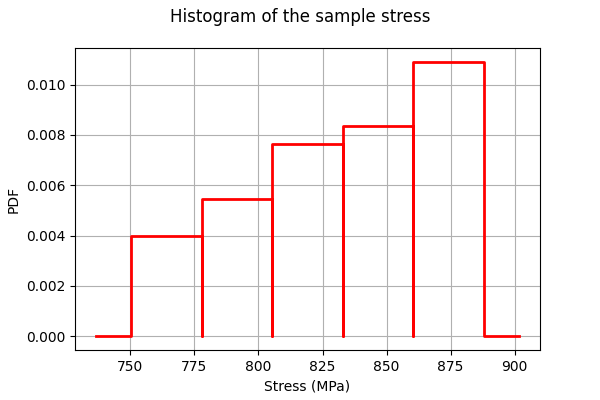

In [7]:
histoGraph = ot.HistogramFactory().build(outputStress/1.e6).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

Generate observation noise.

In [8]:
stressObservationNoiseSigma = 10.e6 # (Pa)
noiseSigma = ot.Normal(0.,stressObservationNoiseSigma)
sampleNoiseH = noiseSigma.getSample(sampleSize)
observedStress = outputStress + sampleNoiseH

In [9]:
observedStrain = inputSample[:,0]

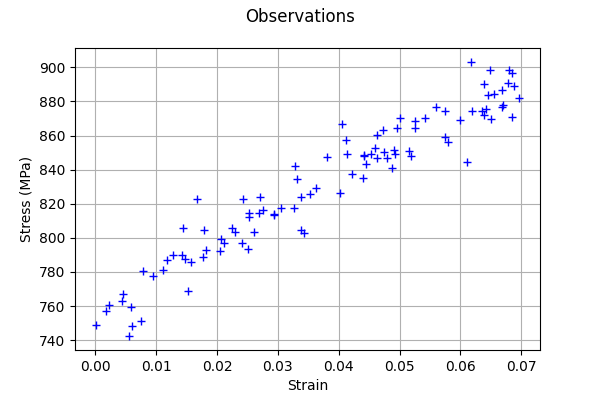

In [10]:
graph = ot.Graph("Observations","Strain","Stress (MPa)",True)
cloud = ot.Cloud(observedStrain,observedStress/1.e6)
graph.add(cloud)
graph

## Set the calibration parameters

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [11]:
R = 700e6 # Exact : 750e6
C = 2500e6 # Exact : 2750e6
Gamma = 8. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])


The following statement create the calibrated function from the model. The calibrated parameters `R`, `C`, `Gamma` are at indices 1, 2, 3 in the inputs arguments of the model.

In [12]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Calibration with linear least squares

The `LinearLeastSquaresCalibration` class performs the linear least squares calibration by linearizing the model in the neighbourhood of the reference point.

In [13]:
algo = ot.LinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior,"SVD")

The `run` method computes the solution of the problem.

In [14]:
algo.run()

In [15]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [16]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.47737e+08,2.79045e+09,10.3362]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [17]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.39694e+08,2.24973e+09,-530.441] upper bound=class=Point name=Unnamed dimension=3 values=[7.55779e+08,3.33117e+09,551.114] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that the `Gamma` parameter has a large confidence interval : even the sign of the parameter is unknown.
The parameter which is calibrated with the smallest confidence
interval is `R`, which confidence interval is [708.3,780.0] (MPa).
This is why this parameter seems the most important in this case.

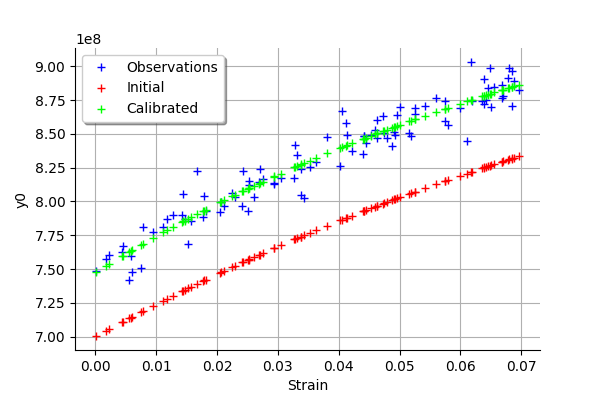

In [18]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

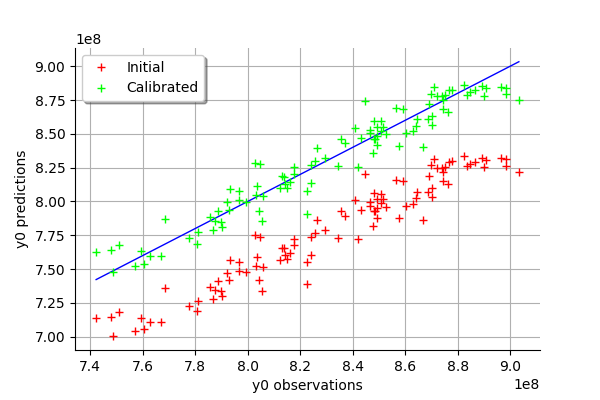

In [19]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [20]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1.10416e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

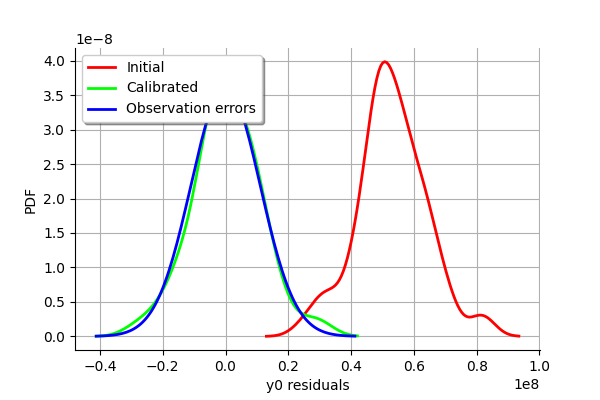

In [21]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. 

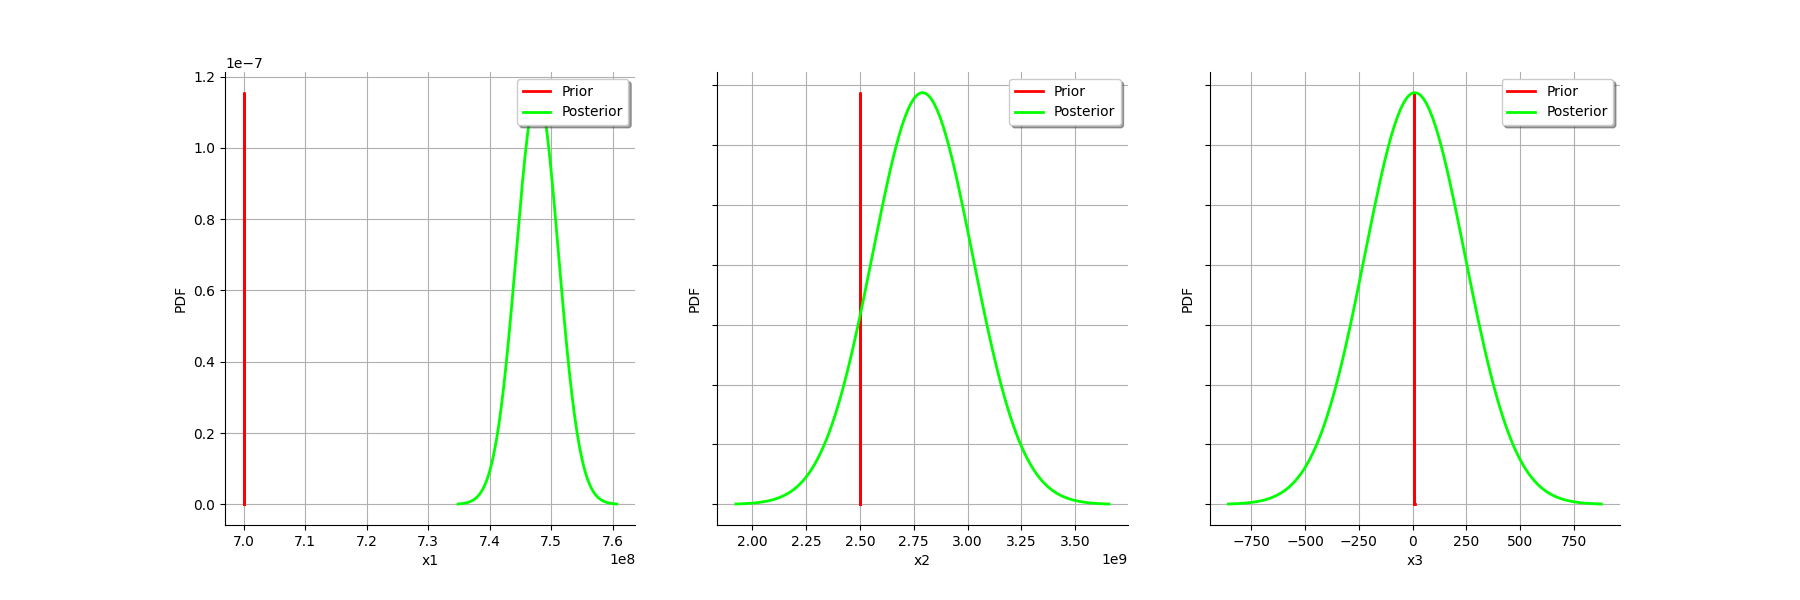

In [22]:
calibrationResult.drawParameterDistributions()

## Calibration with nonlinear least squares

The `NonLinearLeastSquaresCalibration` class performs the non linear least squares calibration by minimizing the squared euclidian norm between the predictions and the observations.

In [23]:
algo = ot.NonLinearLeastSquaresCalibration(mycf, observedStrain, observedStress, thetaPrior)

The `run` method computes the solution of the problem.

In [24]:
algo.run()

In [25]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [26]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.49161e+08,2.68929e+09,9.19248]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [27]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.39711e+08,2.15925e+09,3.34419] upper bound=class=Point name=Unnamed dimension=3 values=[7.57777e+08,3.47188e+09,17.2225] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

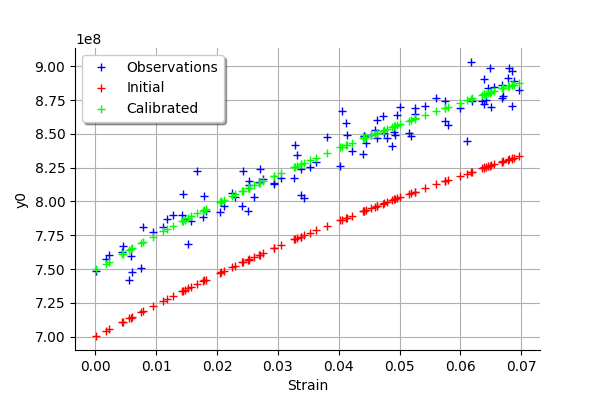

In [28]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

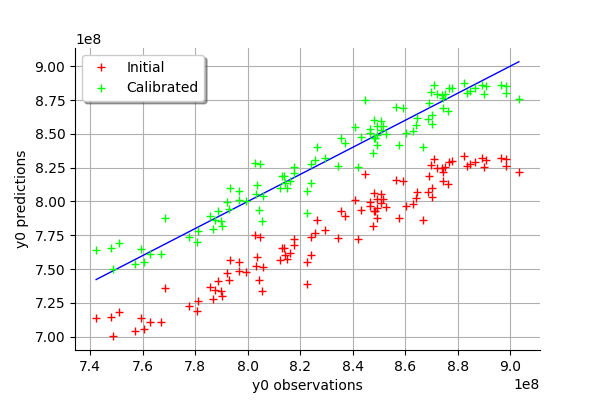

In [29]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

In [30]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[-6381.93] sigma=class=Point name=Unnamed dimension=1 values=[1.09931e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

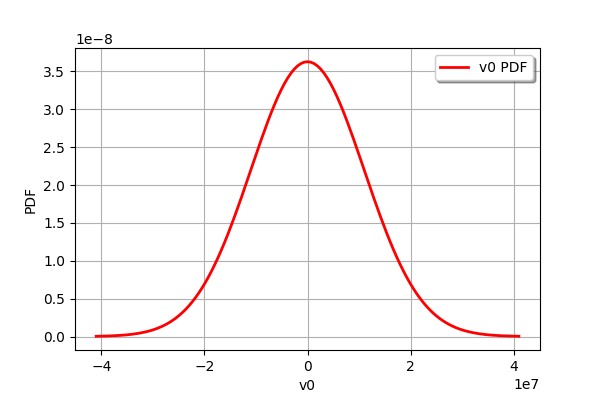

In [31]:
observationError.drawPDF()

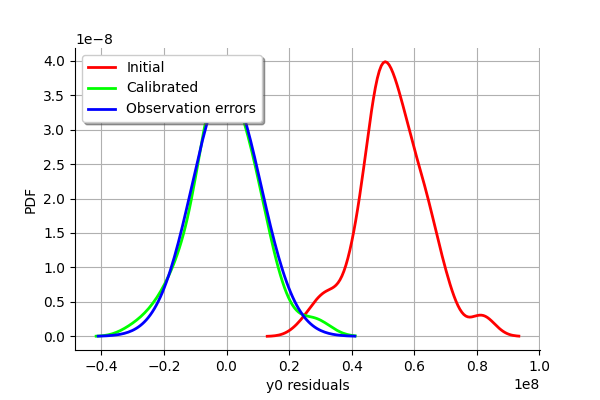

In [32]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the residuals shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian. This indicates that the observation error might be gaussian.

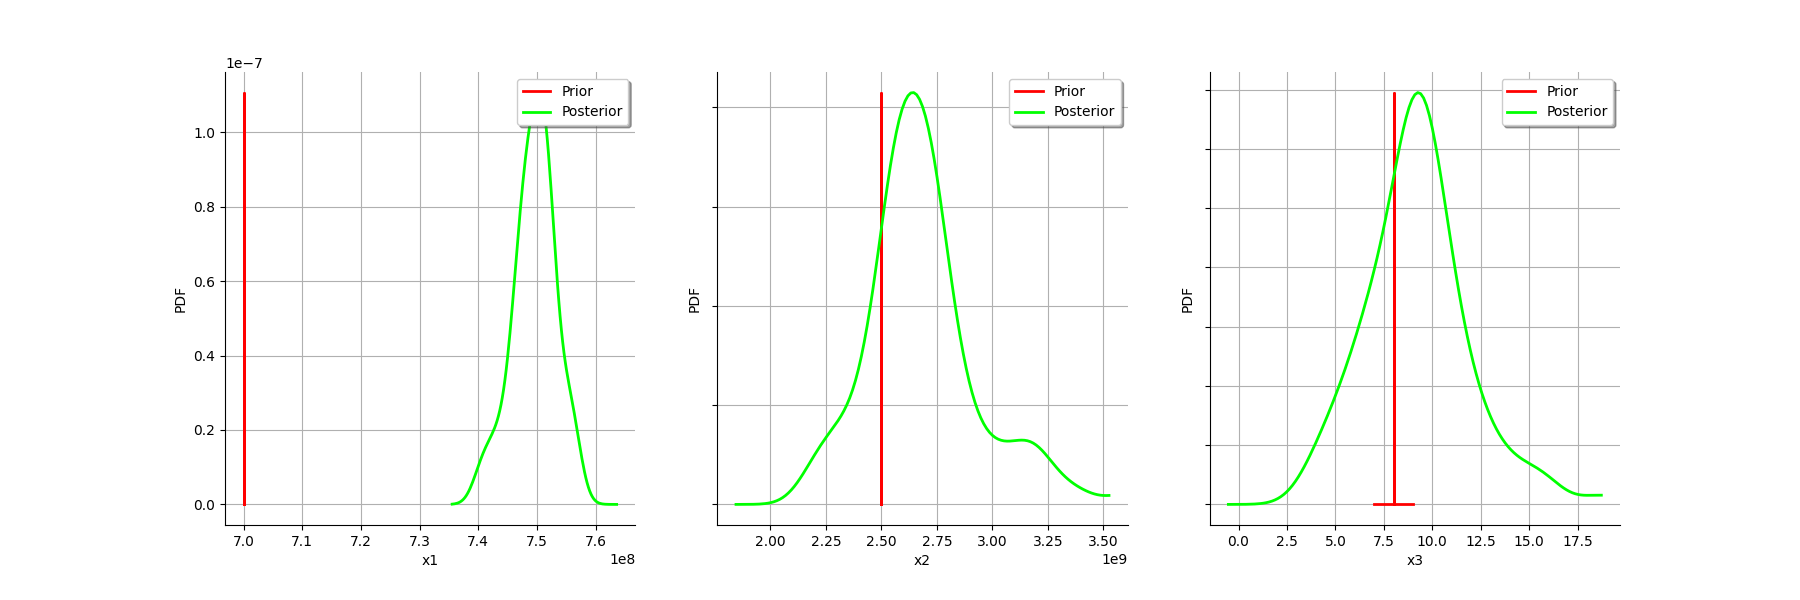

In [33]:
calibrationResult.drawParameterDistributions()

## Gaussian calibration parameters

The standard deviation of the observations errors.

In [34]:
sigmaStress = 1.e7 # (Pa)

Define the covariance matrix of the output Y of the model.

In [35]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaStress**2

Define the covariance matrix of the parameters $\theta$ to calibrate.

In [36]:
sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

In [37]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaR**2
sigma[1,1] = sigmaC**2
sigma[2,2] = sigmaGamma**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4.9e+15,0,0,0,6.25e+16,0,0,0,0.64]

## Gaussian linear calibration

The `GaussianLinearCalibration` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [38]:
algo = ot.GaussianLinearCalibration(mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance)

The `run` method computes the solution of the problem.

In [39]:
algo.run()

In [40]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [41]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.49845e+08,2.60366e+09,8.15841]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [42]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.44583e+08,2.40769e+09,6.45772] upper bound=class=Point name=Unnamed dimension=3 values=[7.55108e+08,2.79962e+09,9.8591] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

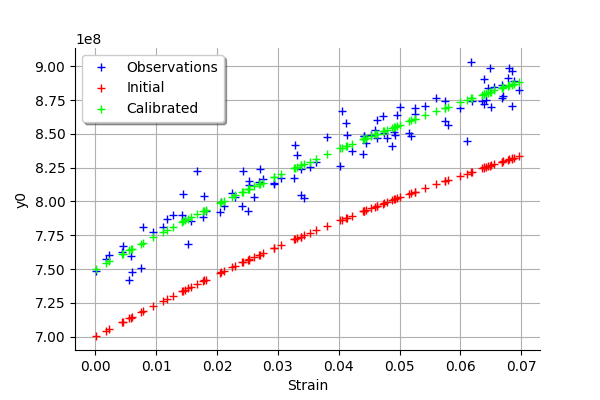

In [43]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

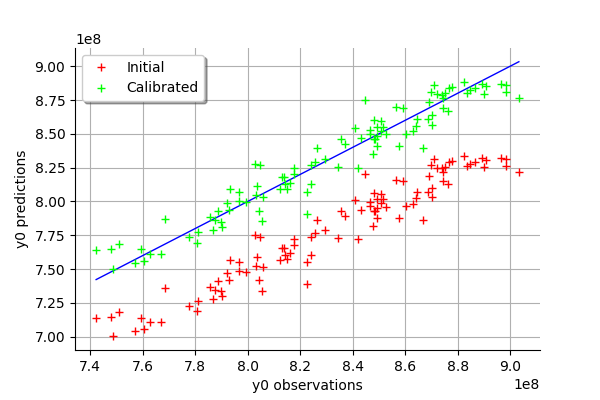

In [44]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by linearizing the problem at the prior. 

In [45]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

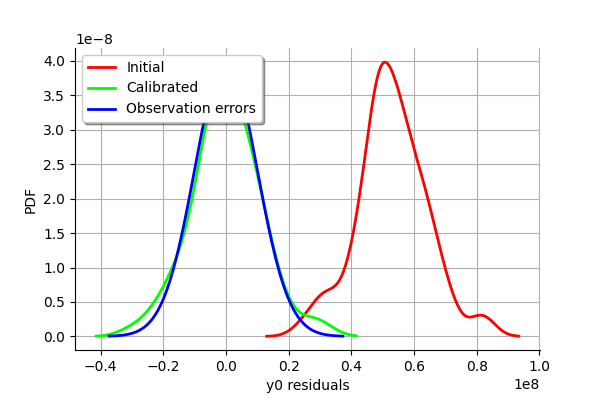

In [46]:
graph = calibrationResult.drawResiduals()
graph.setLegendPosition("topleft")
graph

The analysis of the gaussian distribution (the blue line) of the observation errors is close to the posterior distribution of the residuals (the green line). Moreover, the posterior distribution is centered. These informations indicate that the calibration performed well. 

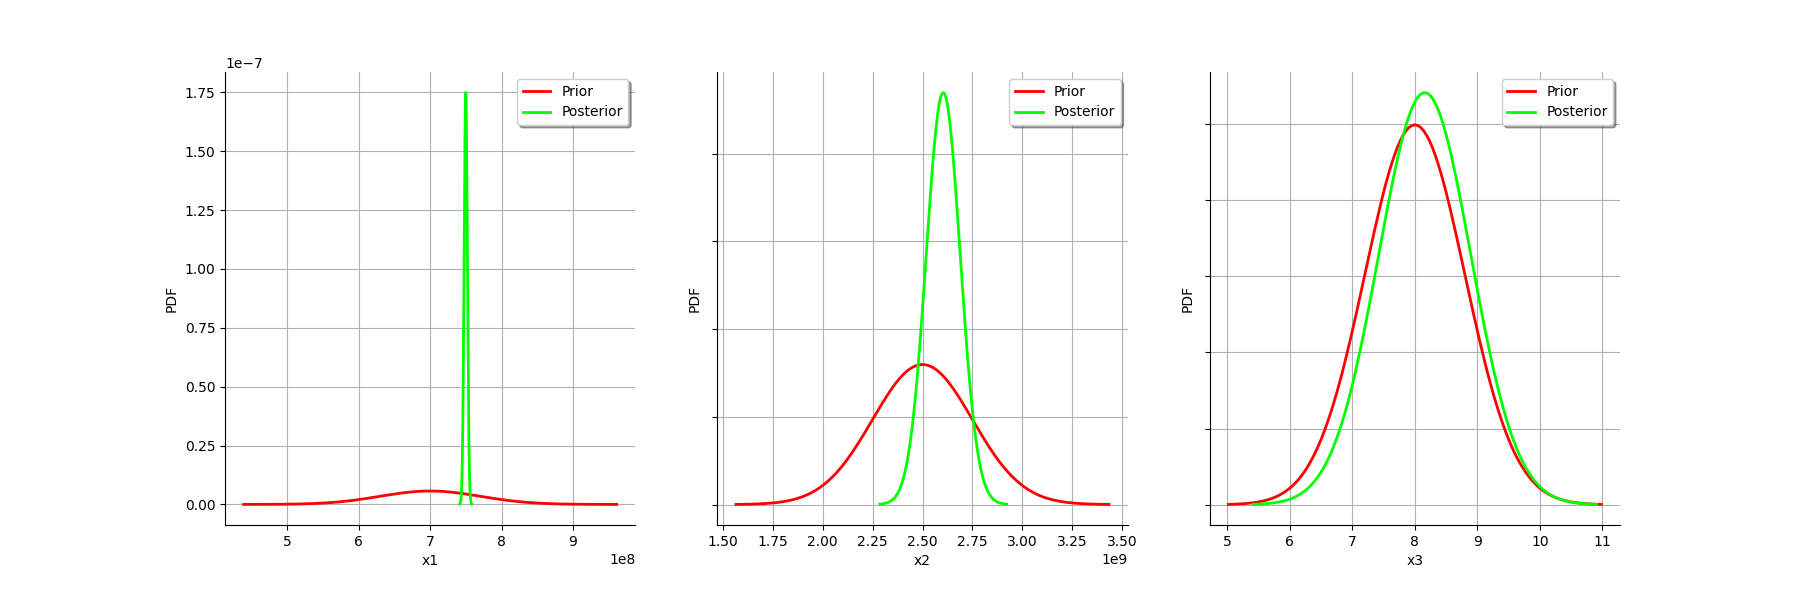

In [47]:
calibrationResult.drawParameterDistributions()

For the $R$ variable, the observations are much more important than the prior: this is shown by the fact that the posterior and prior distribution of the $R$ variable are very different. 

We see that the prior and posterior distribution are close to each other for the $\gamma$ variable: the observations did not convey much information for this variable. 

## Gaussian nonlinear calibration

The `GaussianNonLinearCalibration` class performs the gaussian nonlinear calibration.

In [48]:
algo = ot.GaussianNonLinearCalibration(mycf, observedStrain, observedStress, thetaPrior, sigma, errorCovariance)

The `run` method computes the solution of the problem.

In [49]:
algo.run()

In [50]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [51]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[7.50505e+08,2.57712e+09,8.00567]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [52]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[7.44181e+08,2.42749e+09,7.43243] upper bound=class=Point name=Unnamed dimension=3 values=[7.55607e+08,2.77307e+09,8.61892] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

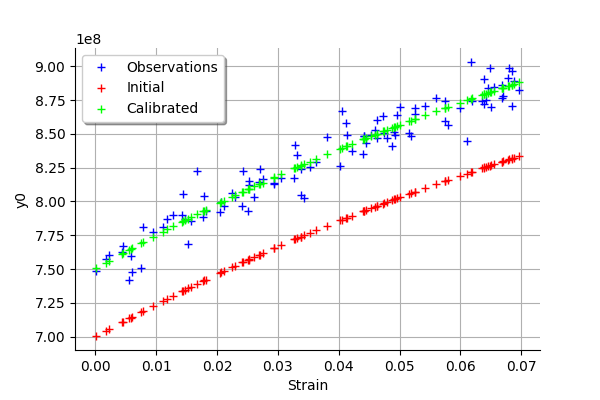

In [53]:
graph = calibrationResult.drawObservationsVsInputs()
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

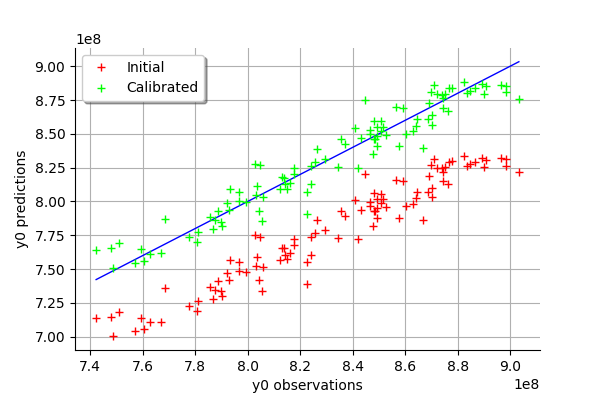

In [54]:
calibrationResult.drawObservationsVsPredictions()

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by bootstraping the problem at the posterior. 

In [55]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

This can be compared to the residuals distribution, which is computed at the posterior.

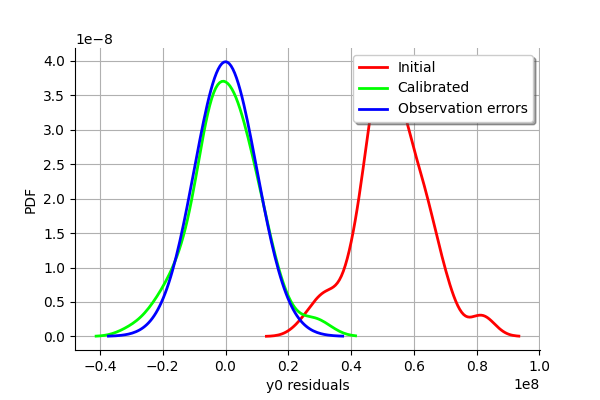

In [56]:
calibrationResult.drawResiduals()

The analysis is very similar to the linear calibration. 

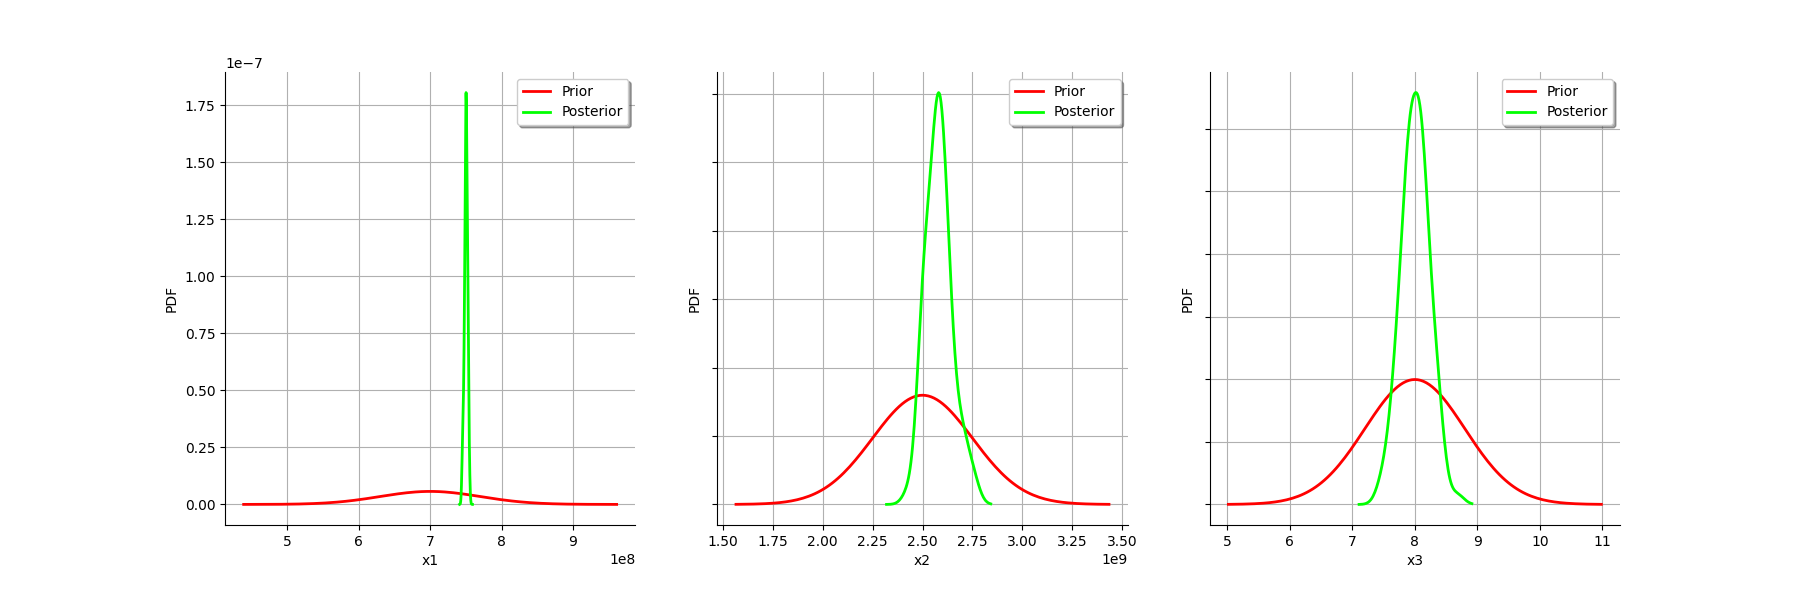

In [57]:
calibrationResult.drawParameterDistributions()

We see that the prior and posterior distribution for the $\gamma$ parameter are close to each other, but not superimposed: the observations significantly brought information to the variable $\gamma$ during the calibration.